## External AIS Data Analysis

Source: https://hub.marinecadastre.gov/pages/vesseltraffic

Downloaded: 2024-01-01 dataset for EDA purpose

Observations & thoughts:
* 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import sys, os

sys.path.append(os.path.abspath('..'))

#Loading in preprocessed dataset
ais = pd.read_csv('../../data/external_ais/cleaned_AIS_2024_01_01.csv')

#convert into proper datetime
ais['datetime'] = pd.to_datetime(ais.loc[:,'datetime'])

In [91]:
#helper function to plot tracks:
#helper plotting function

def plot_single_trajectory(track_data, start = 0, end = 1):
    """
    Args:
        track_data: pd dataframe; detections associated with 1 track
    """
    assert len(track_data['id_track'].unique()) == 1, "track_data must be associated with 1 track"

    track_id = track_data['id_track'].iloc[0]  # Ensure we grab the first element of the track id
    track_data = track_data.sort_values('datetime')
    if 'type_m2' in track_data.columns:
        type_m2 = track_data['type_m2'].iloc[0]

    #plot only a portion of the data
    nrows = len(track_data)
    start_row = int(nrows * start)
    end_row = int(nrows * end)
    track_data = track_data.iloc[start_row:end_row]

    # Calculate duration
    start_time = track_data['datetime'].iloc[0]
    end_time = track_data['datetime'].iloc[-1]
    duration = end_time - start_time
    total_seconds = int(duration.total_seconds())
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    duration_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

    # Create figure and axis for a single plot
    fig, ax = plt.subplots(figsize=(5, 4))

    # Plot trajectory
    ax.plot(track_data['longitude'], track_data['latitude'], 
            marker='o', markersize=2, linewidth=1, alpha=0.6)

    # Add start and end points
    ax.scatter(track_data['longitude'].iloc[0], track_data['latitude'].iloc[0], 
                color='green', marker='^', s=100, label='Start')
    ax.scatter(track_data['longitude'].iloc[-1], track_data['latitude'].iloc[-1], 
                color='red', marker='v', s=100, label='End')

    # Customize plot
    ax.set_title(f'Track {track_id}\nDuration: {duration_str}\nNumber of detections: {end_row - start_row}\nType: {type_m2}')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.grid(True)
    ax.legend()
    plt.xticks(rotation=45)

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


def plot_group_trajectory(df, num_samples = 10, proportion = 1):
    """
        Plot trajectories of vessel of type based on radar detections

        Args: 
        mode: 'type', 'activity' or 'activity_inferred'
        type: vessel type or activity of interest
        num_samples: number of random trajectories to be plotted

    """
    track_ids = df['id_track'].unique()
    sampled_tracks = np.random.choice(track_ids, size = num_samples, replace = False)

    # Create subplot grid
    n_rows = num_samples // 5
    fig, axes = plt.subplots(n_rows, 5, figsize=(20, 5*n_rows))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Plot each trajectory
    for idx, track_id in enumerate(sampled_tracks):
        track_data = df[df['id_track'] == track_id].sort_values('datetime') 
        track_data = track_data.iloc[:int(len(track_data) * proportion)]
        type_m2 = track_data['type_m2'].iloc[0]
        confidence_score = track_data['activity_confidence_score'].iloc[0]

        # Calculate duration
        start_time = pd.to_datetime(track_data['datetime'].iloc[0])
        end_time = pd.to_datetime(track_data['datetime'].iloc[-1])
        duration = end_time - start_time
        total_seconds = int(duration.total_seconds())
        hours = total_seconds // 3600
        minutes = (total_seconds % 3600) // 60
        seconds = total_seconds % 60
        duration_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

        # Plot trajectory
        axes[idx].plot(track_data['longitude'], track_data['latitude'], 
                    marker='o', markersize=2, linewidth=1, alpha=0.6)

        # Add start and end points
        axes[idx].scatter(track_data['longitude'].iloc[0], track_data['latitude'].iloc[0], 
                        color='green', marker='^', s=100, label='Start')
        axes[idx].scatter(track_data['longitude'].iloc[-1], track_data['latitude'].iloc[-1], 
                        color='red', marker='v', s=100, label='End')

        # Customize subplot
        axes[idx].set_title(f'Track {track_id}\nDuration: {duration_str}\nDetections: {len(track_data)}\nType: {type_m2}\nConfidence: {confidence_score}')
        axes[idx].set_xlabel('Longitude')
        axes[idx].set_ylabel('Latitude')
        axes[idx].tick_params(axis='x', labelrotation=45)
        axes[idx].grid(True)
        axes[idx].legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()



In [48]:
ais.head()

,id_track,latitude,longitude,speed,course,Heading,VesselName,TransceiverClass,datetime,type_m2
0,0,36.91335,-76.18495,0.0,171.9,171.0,CG49420,B,2024-01-01 00:01:59,search_and_rescue_boat
1,0,36.91334,-76.18494,0.0,176.7,176.0,CG49420,B,2024-01-01 00:04:59,search_and_rescue_boat
2,0,36.91334,-76.18496,0.0,181.1,181.0,CG49420,B,2024-01-01 00:07:59,search_and_rescue_boat
3,0,36.91335,-76.18495,0.0,178.1,178.0,CG49420,B,2024-01-01 00:13:59,search_and_rescue_boat
4,0,36.91335,-76.18497,0.0,179.7,179.0,CG49420,B,2024-01-01 00:16:59,search_and_rescue_boat


### EDAs

In [49]:
#this is just 2024-01-01 data!!
print(f'Total number of detection points: {len(ais)}')
print(f'Total number of vessels: {len(ais["id_track"].unique())}')

Total number of detection points: 7191020
Total number of vessels: 12740


In [50]:
unique = ais.drop_duplicates(subset=['id_track'], keep='first')

unique['TransceiverClass'].value_counts()

TransceiverClass
A    6602
B    6138
Name: count, dtype: int64

In [51]:
#notice class B vessel here is more granular than our provided dataset!
unique[unique['TransceiverClass'] == 'B'].head(3)

,id_track,latitude,longitude,speed,course,Heading,VesselName,TransceiverClass,datetime,type_m2
0,0,36.91335,-76.18495,0.0,171.9,171.0,CG49420,B,2024-01-01 00:01:59,search_and_rescue_boat
396,3381234,34.71526,-76.70942,0.6,98.5,511.0,ZEEPAARD,B,2024-01-01 00:01:03,sailboat
2428,103669999,30.36441,-89.08701,0.0,172.5,511.0,MILADY,B,2024-01-01 00:03:15,pleasure_craft


### Trajectory Plot

In [53]:
ais['id_track'].sample(10)

3563795    367450580
4865058    367741210
1450762    338474947
6709591    369970316
355467     316005667
6305599    368274170
643228     319076300
4410898    367643150
6693261    369604000
6764381    374233000
Name: id_track, dtype: int64

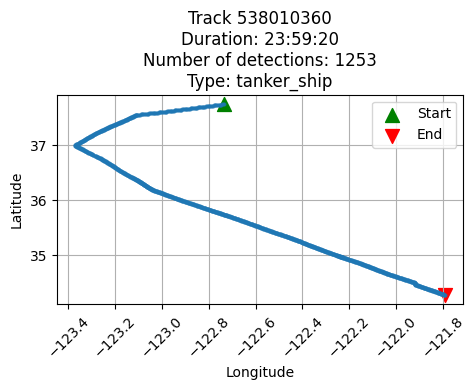

In [ ]:
#normal track example
track = ais[ais['id_track'] == 538010360]
plot_single_trajectory(track, 0, 1)

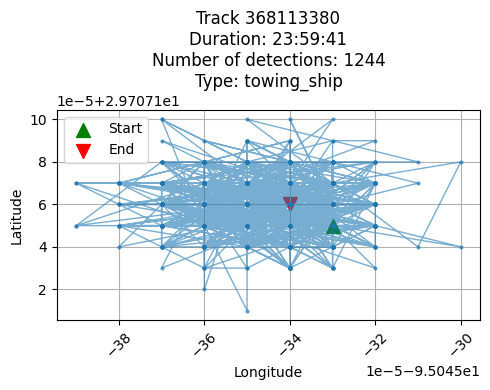

In [ ]:
#stopped track example: looks like discretized but its actually stopped
#note x,y axis scales are 1e-5 magnitude
track = ais[ais['id_track'] == 368113380]
plot_single_trajectory(track)

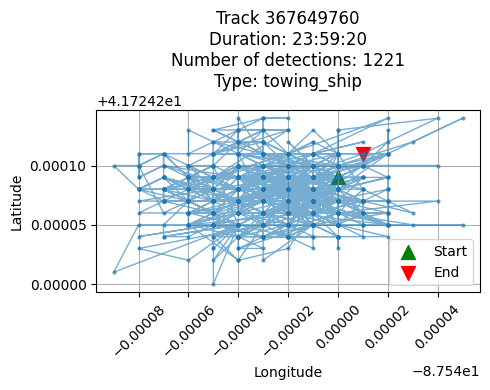

In [70]:
#another stopped
track = ais[ais['id_track'] == 367649760]
plot_single_trajectory(track)

### Test XGboost Activity Model

In [57]:
from core.sum_stats import SumStatsBaseline

summary_df = SumStatsBaseline(ais)()

In [58]:
from core.sum_stats import SumStatsBaseline
import joblib
import json
from core.DICT import NUM2ACTIVITY

activity_model = joblib.load("../sum_stats/models/xgboost_activity.pkl")
with open("../sum_stats/models/xgboost_activity_desc.json", "r") as f:
    model_info = json.load(f)

features_subset = model_info['features']

X = summary_df[features_subset]
y_pred_numeric = activity_model.predict(X)
y_pred = [NUM2ACTIVITY[i] for i in y_pred_numeric]

#get confidence score
y_pred_prob = activity_model.predict_proba(X)
confidence_scores = y_pred_prob.max(axis = 1)

summary_df['activity_inferred'] = y_pred
summary_df['activity_inferred'].value_counts()
summary_df['activity_confidence_score'] = confidence_scores

In [59]:
summary_df['activity_inferred'].value_counts()

activity_inferred
stopped     7902
seine       1159
lobster     1096
transit      910
hook         794
drifting     481
trawl        398
Name: count, dtype: int64

#### Examine Transit Inferred

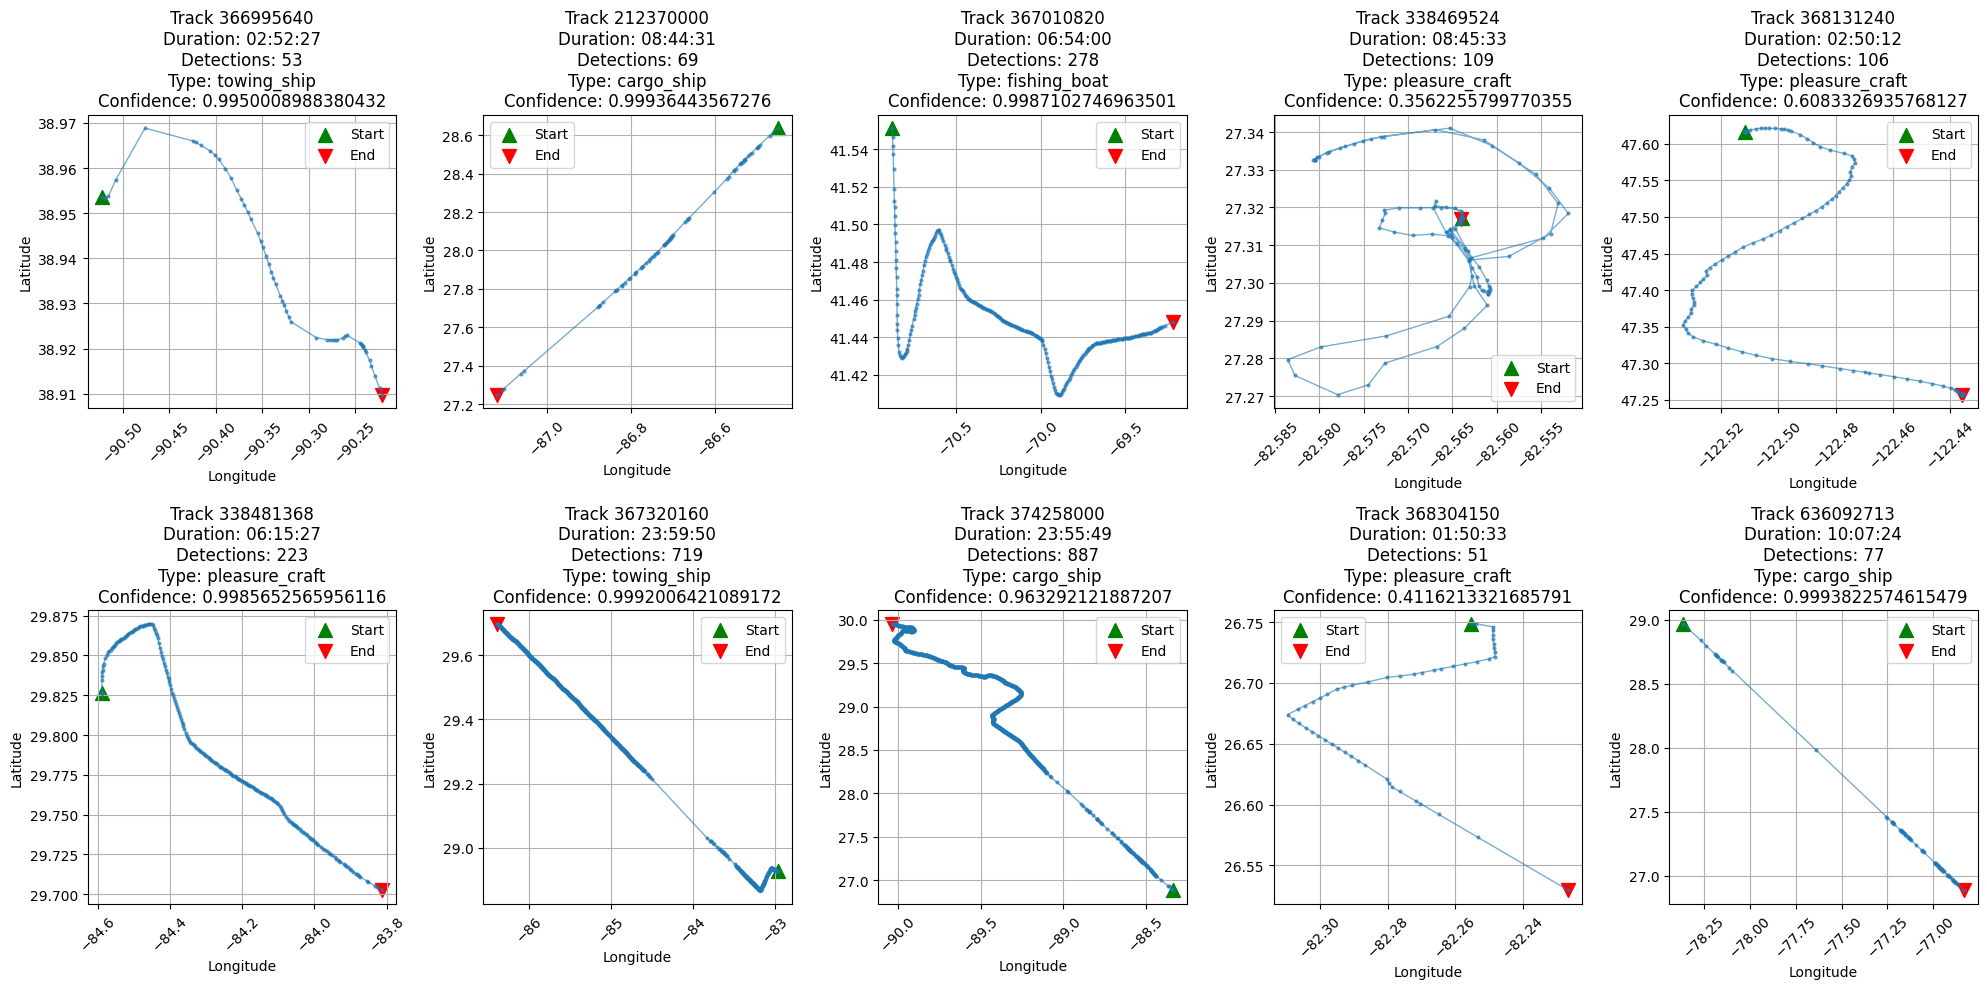

In [ ]:
transit = summary_df[summary_df['activity_inferred'] == 'transit']
transit_detections = pd.merge(ais, transit, on = 'id_track', how = 'inner')
plot_group_trajectory(transit_detections, 10)

#### Examine Stopped inferred

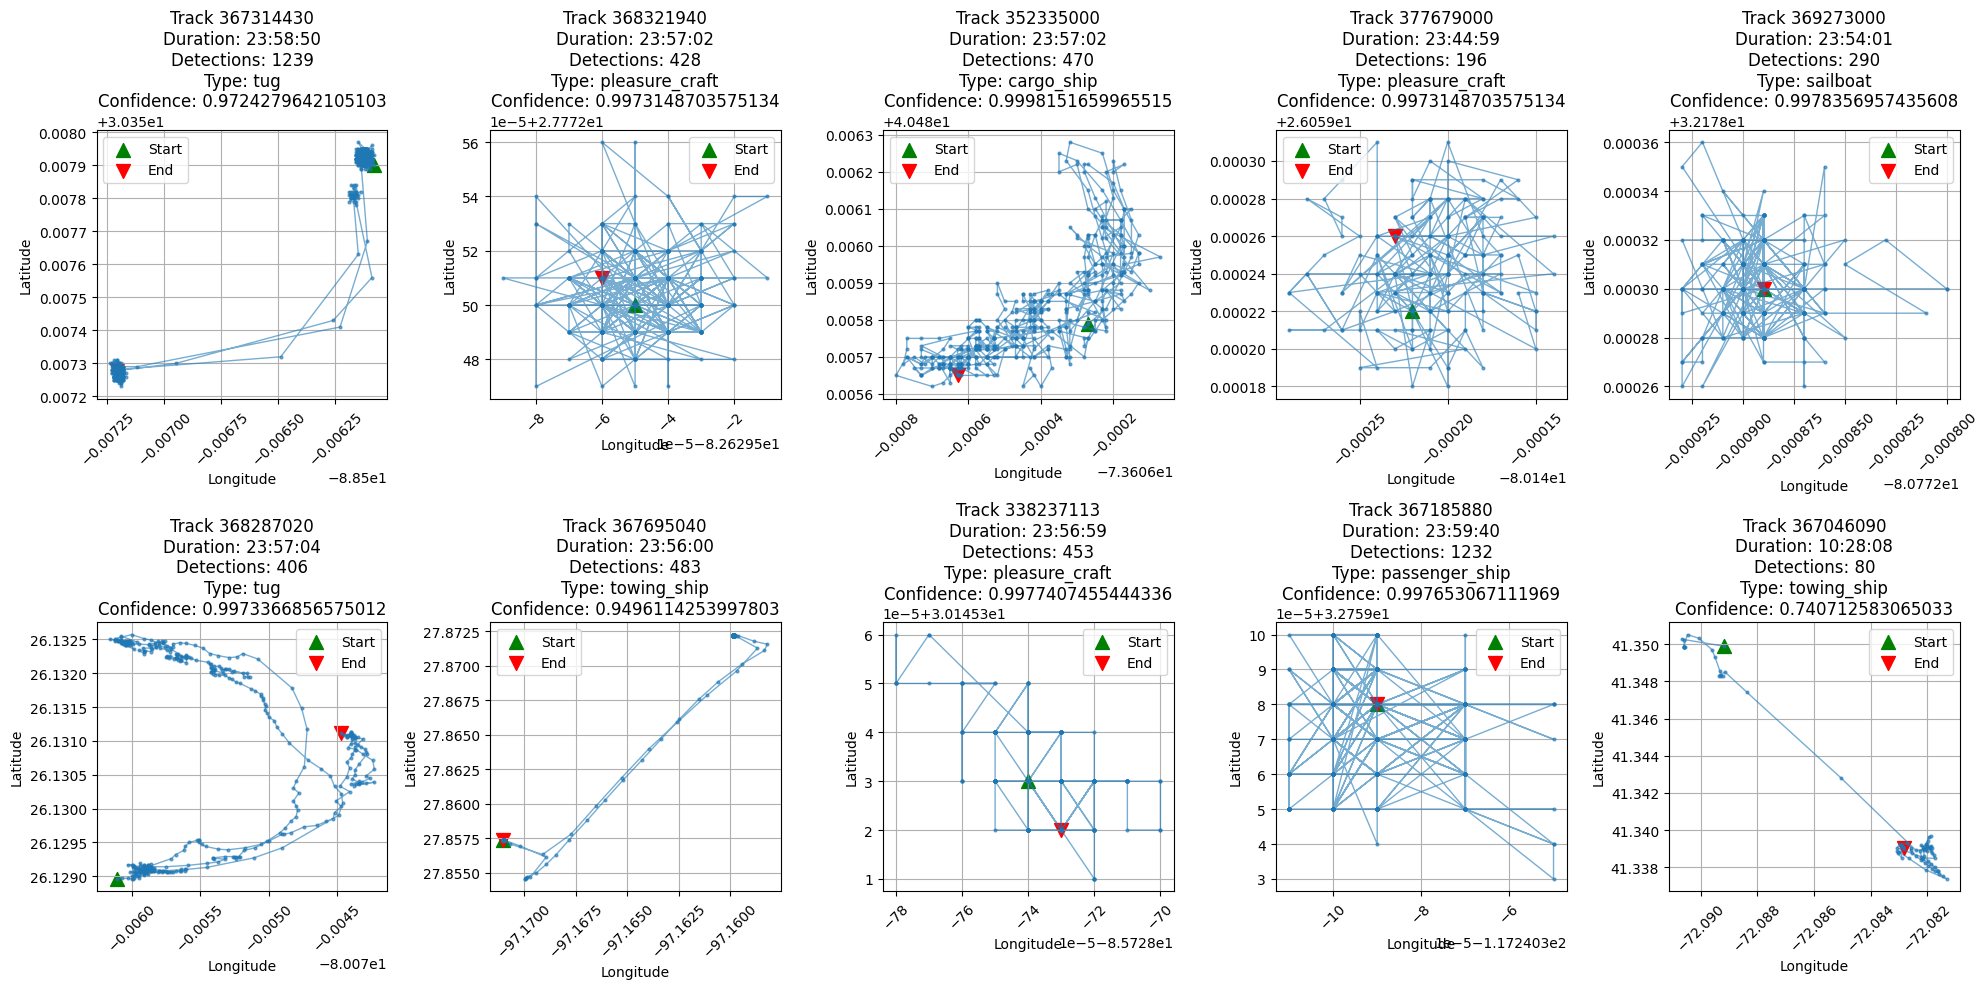

In [88]:
stopped = summary_df[summary_df['activity_inferred'] == 'stopped']
stopped_detections = pd.merge(ais, stopped, on = 'id_track', how = 'inner')
plot_group_trajectory(stopped_detections, 10)

#### Examine Lobster Inferred

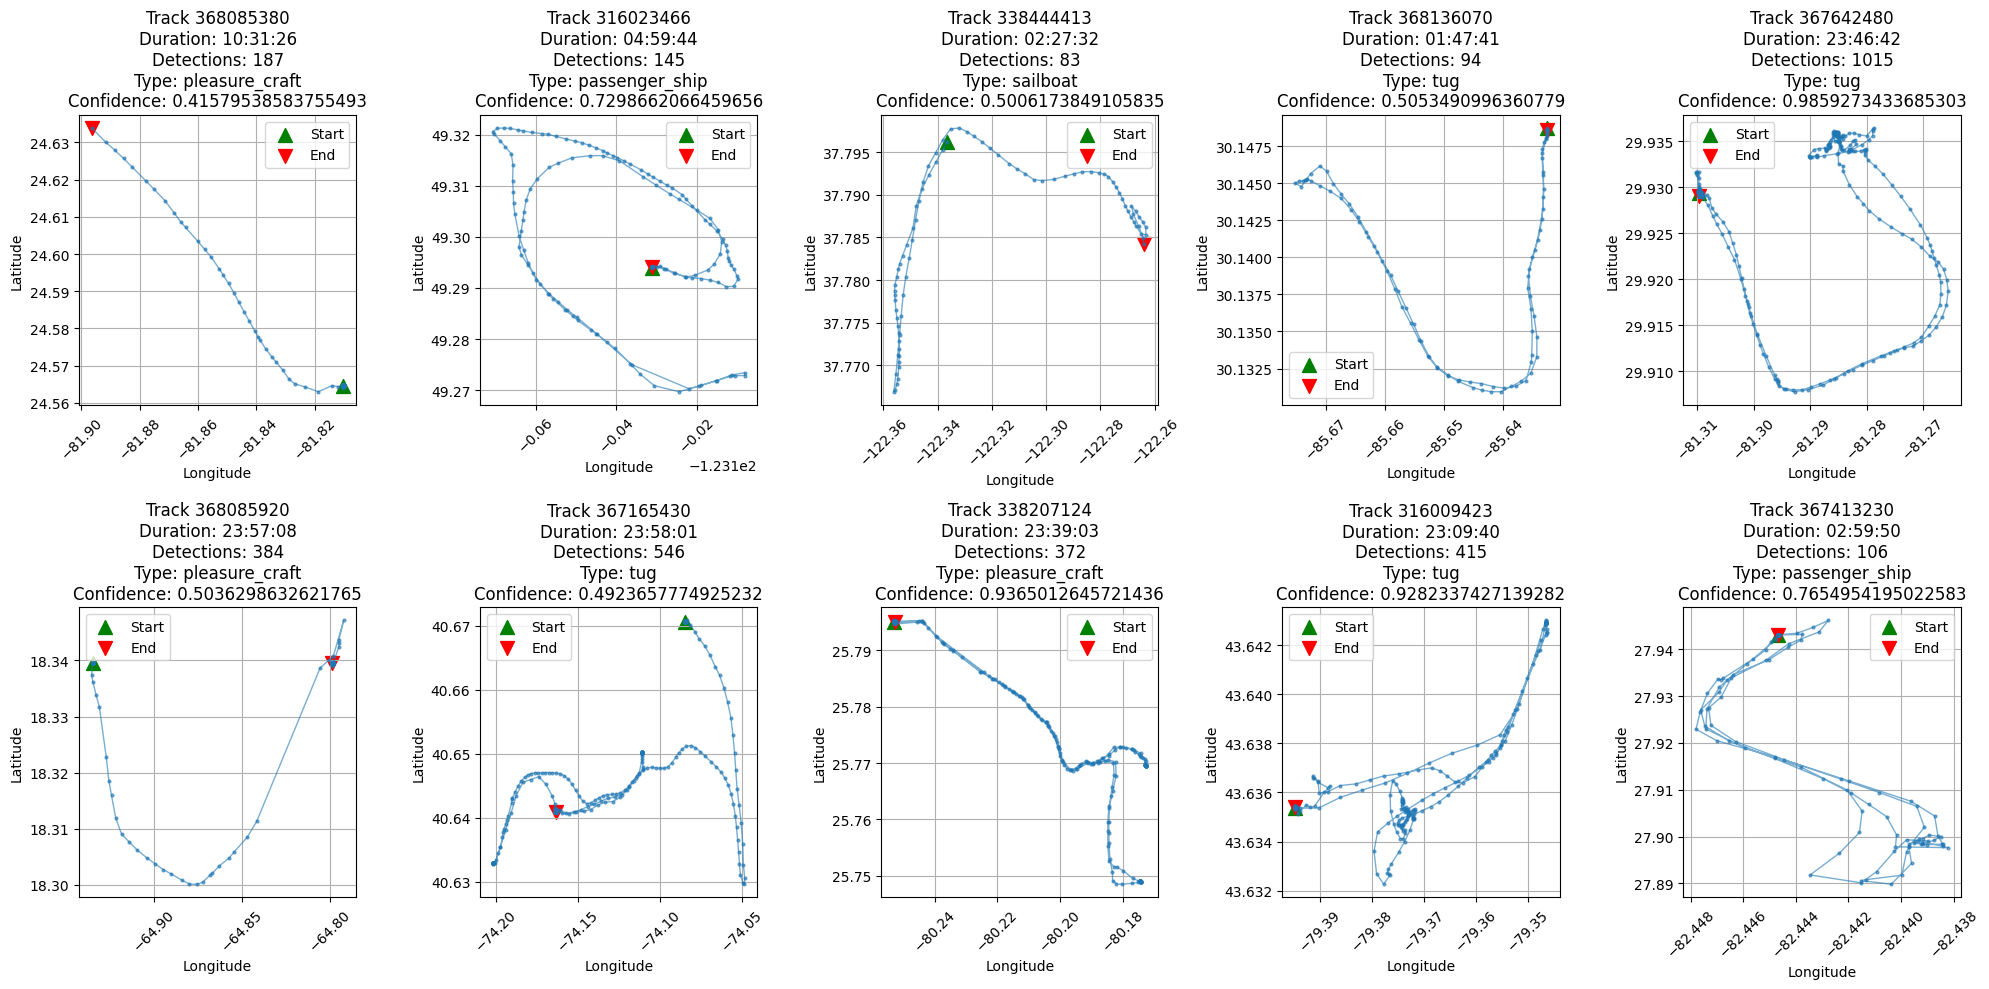

In [ ]:
lobster = summary_df[summary_df['activity_inferred'] == 'lobster']
loster_detections = pd.merge(ais, lobster, on = 'id_track', how = 'inner')
plot_group_trajectory(loster_detections, 10)

#### Examine All Non-transit

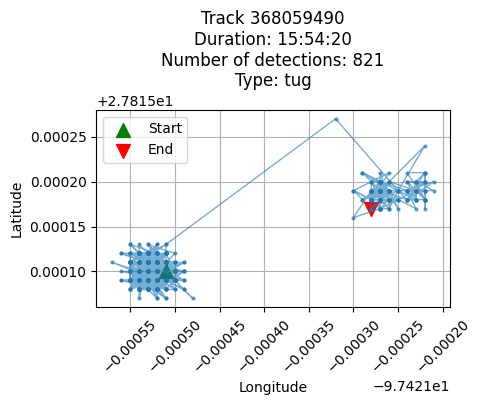

,id_track,duration,distance_total,detections,max_speed,min_speed,avg_speed,heading_mean,heading_std,turning_mean,turning_std,distance_o,curviness,activity_inferred,activity_confidence_score
9217,368059490,0 days 23:59:31,73.776157,1245,7.8,0.0,1.639438,170.69476,1.094522,3.841801,19.929673,48.190947,1.530913,seine,0.956352


In [80]:
track = ais[ais['id_track'] == 368059490]
plot_single_trajectory(track, 0, 0.66)

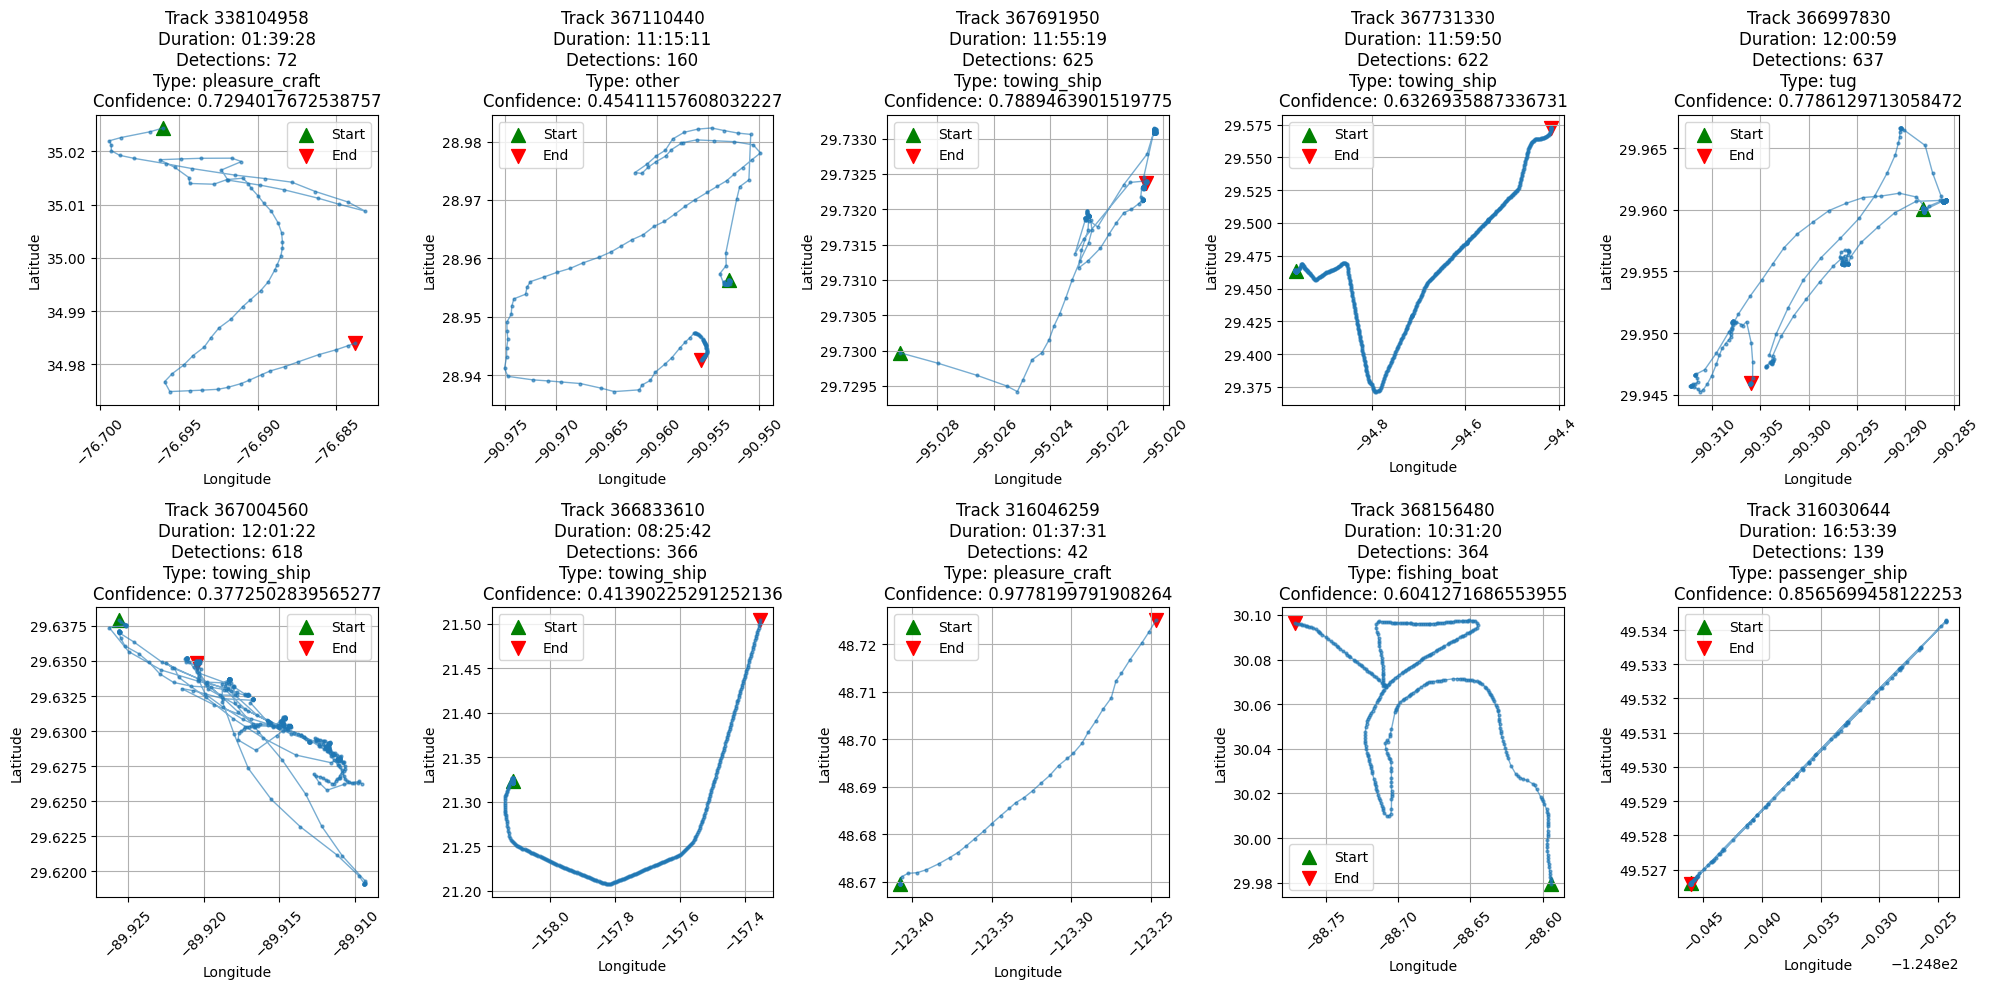

In [95]:
non_transit = summary_df[
    (summary_df['activity_inferred'] != 'transit') & 
    (summary_df['activity_inferred'] != 'stopped')
]
nontransit_detections = pd.merge(ais, non_transit, on = 'id_track', how = 'inner')
plot_group_trajectory(nontransit_detections, 10, 0.5)

### Comparison of M2 radar detections & AIS detections

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import sys, os

sys.path.append(os.path.abspath('..'))

#Loading in preprocessed dataset
ais = pd.read_csv('../../data/external_ais/cleaned_AIS_2024_01_01.csv')
radar = pd.read_csv('../../data/cleaned_data/preprocessed_radar_detections.csv')

#convert into proper datetime
ais['datetime'] = pd.to_datetime(ais.loc[:,'datetime'])
radar['datetime'] = pd.to_datetime(radar.loc[:,'datetime'])

In [10]:
#Modify SumstatsBaseline to calculate variables of interests
import warnings

class SumStatsUtils:

    """
    Modified SumStatsBaseline to calculate variables of interests
    """
    R = 6371 #km

    def __init__(self, preprocessed_radar_detections):
        self.df = preprocessed_radar_detections
        
    def __call__(self): 
        summary_df = self.df.groupby('id_track').apply(self.compute_track_stats)
        return summary_df.reset_index()
    
    def compute_track_stats(self, group):
        n_detect = len(group)
        
        with warnings.catch_warnings():
            warnings.simplefilter(action='ignore', category=UserWarning)
            group['datetime'] = pd.to_datetime(group['datetime'], errors='coerce')
        group = group.sort_values(by='datetime').copy()

        group['latitude_prev'] = group['latitude'].shift(1)
        group['longitude_prev'] = group['longitude'].shift(1)
        group['distance_diff'] = self._haversine_distance(
            group['latitude_prev'], group['longitude_prev'],
            group['latitude'], group['longitude']
        )
        group['time_prev'] = group['datetime'].shift(1)
        group['time_diff'] = (group['datetime'] - group['time_prev']).dt.total_seconds()
        
        #Duration Calculation
        duration = (group["datetime"].iloc[-1] - group["datetime"].iloc[0]).total_seconds()/60 #minutes
        min_interval = group['time_diff'].min()
        max_interval = group['time_diff'].max()
        avg_interval = group['time_diff'].mean()
        
        #Distance Travelled and Spanned Area (approximate) Calculation
        total_distance = np.sum(group['distance_diff'])
        max_lat = np.radians(group['latitude'].max())
        min_lat = np.radians(group['latitude'].min())
        max_lon = np.radians(group['longitude'].max())
        min_lon = np.radians(group['longitude'].min())
        area = self.R**2 * abs(max_lon - min_lon) * abs(np.sin(max_lat) - np.sin(min_lat))

        # Speed is in kts, Distance is in km, Heading / Turning in Deg
        track_summary = {
            "duration"       : duration,
            "min_interval"   : min_interval,
            "max_interval"   : max_interval,
            "avg_interval"   : avg_interval,
            "total_distance" : total_distance,
            "area"           : area,
            "detections"     : n_detect
        }

        if 'type_m2' in group.columns:
            track_summary['type_m2'] = group['type_m2'].iloc[0]
        if 'activity' in group.columns:
            track_summary['activity'] = group['activity'].iloc[0]
        return pd.Series(track_summary)
    
    @staticmethod
    def _circular_mean(angles):
        """
        Calculate the circular mean of a list of angles.
        Inputs: angles(pd series): angles in degress
        Returns: circular mean of the angles in degrees
        """
        angles = angles * np.pi / 180
        x = np.cos(angles)
        y = np.sin(angles)
        return np.arctan2(np.sum(y), np.sum(x)) * 180 / np.pi

    @staticmethod
    def _circular_std(angles):
        """
        Calculate the circular standard deviation of a list of angles
        Args:
            angles(pd series): angles in degress
        Returns:
            float: circular std of the angles in degrees
        """
        angles = angles * np.pi / 180
        x = np.cos(angles).sum()
        y = np.sin(angles).sum()
        x /= len(angles)
        y /= len(angles)
        R = np.sqrt(x**2 + y**2)
        std = np.sqrt(-2 * np.log(R)) * 180 / np.pi
        return std
    
    @staticmethod
    def _haversine_distance(lat1, lon1, lat2, lon2, r = 6371):
        """
        Calculate the distance between two points on the Earth's surface
        using the Haversine formula.

        Args:
            lat1 (float): Latitude of the first point
            lon1 (float): Longitude of the first point
            lat2 (float): Latitude of the second point
            lon2 (float): Longitude of the second point
            r (float): Radius of the Earth in kilometers
            
        Returns:
            Distance in km
        """
        delta_phi = np.radians(lat2 - lat1)
        delta_lambda = np.radians(lon2 - lon1)
        a = np.sin(delta_phi / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(delta_lambda / 2) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return r * c

    


In [11]:
ais_summary = SumStatsUtils(ais)()
radar_summary = SumStatsUtils(radar)()

/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_82135/1332088421.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = self.df.groupby('id_track').apply(self.compute_track_stats)
/var/folders/jm/bv3tgs257hx9tx764_p9xq0w0000gn/T/ipykernel_82135/1332088421.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_df = self.df.groupby('id_track').apply(self.compute_track_stats)


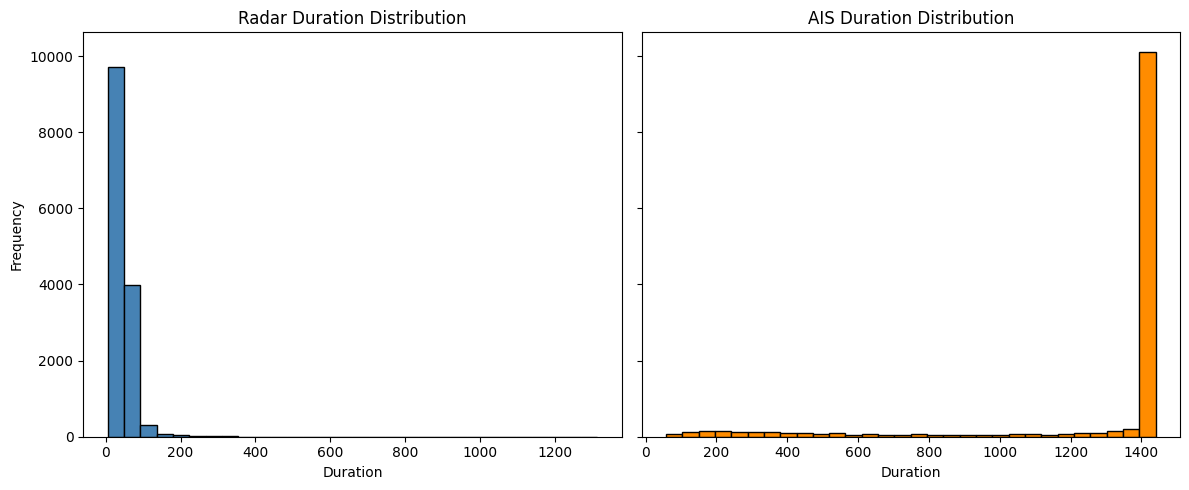

In [23]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Histogram for radar_summary
axs[0].hist(radar_summary['duration'], bins=30, color='steelblue', edgecolor='black')
axs[0].set_title('Radar Duration Distribution')
axs[0].set_xlabel('Duration')
axs[0].set_ylabel('Frequency')

# Histogram for ais_summary
axs[1].hist(ais_summary['duration'], bins=30, color='darkorange', edgecolor='black')
axs[1].set_title('AIS Duration Distribution')
axs[1].set_xlabel('Duration')

# Display the plots
plt.tight_layout()
plt.show()


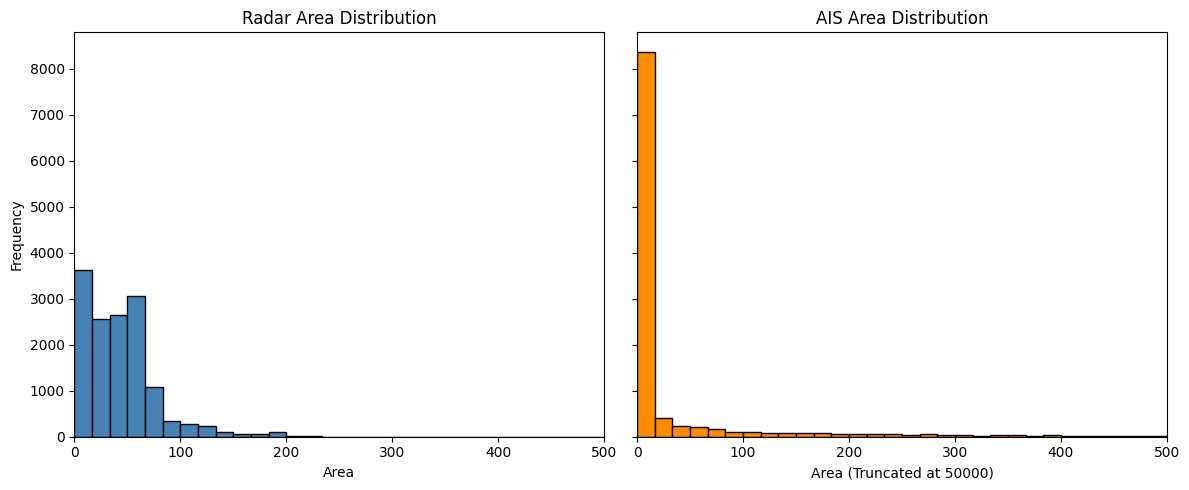

In [36]:
import matplotlib.pyplot as plt

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Histogram for radar_summary
axs[0].hist(radar_summary['area'], bins=np.linspace(0, 500, 31), color='steelblue', edgecolor='black')
axs[0].set_title('Radar Area Distribution')
axs[0].set_xlabel('Area')
axs[0].set_ylabel('Frequency')
axs[0].set_xlim(0, 500)

# Histogram for ais_summary
axs[1].hist(ais_summary['area'], bins=np.linspace(0, 500, 31), color='darkorange', edgecolor='black')
axs[1].set_title('AIS Area Distribution')
axs[1].set_xlabel('Area (Truncated at 50000)')
axs[1].set_xlim(0, 500)

# Display the plots
plt.tight_layout()
plt.show()


In [43]:
#radar generally pins every 6 secs
radar_summary['avg_interval'].describe()

count    14204.000000
mean         7.136386
std          0.790514
min          6.108108
25%          6.686443
50%          6.902802
75%          7.352638
max         27.271318
Name: avg_interval, dtype: float64

In [45]:
#ais generally pins every 1-3 min, much less granular
ais_summary['avg_interval'].describe()


count    12740.000000
mean       209.005227
std        184.447534
min         61.070033
25%         84.576329
50%        185.426882
75%        231.617807
max       1713.380000
Name: avg_interval, dtype: float64